# **Chapter 10**  
**┗ 보험청구 사기 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「의미있는 변수 선택」
* 🥈Session 2 - 「사기 거래 특성 파악」
* 🥇Session 3 - 「ML 활용 사기 거래 예측」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter10')
# '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter10' ← 변경X
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter10'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🚐😬 (보험비용 처리가)

```
최근 국제 유가가 떨어지고 있어, 기름값이 저렴해졌다. 이에 많은 사람들이 평소보다 더 차량을 구매하는 현상이 발생하고 있다.  
자동차 보험사는 신규 가입회원이 늘어나고 있어 행복한 하루를 보내고 있으나, 한편으로는 걱정이 많다. 그만큼 보험청구 사기 건수도  
증가하고 있기 때문이다. 

```  

> **데이터 살펴보기**

* 보험 청구건에 대한 사고 관련 정보 및 청구 금액 정보
* 데이터를 크게 3가지 카테고리로 구분할 수 있음: 고객 프로필 정보 / 보험 청구 및 사고 이력 정보/ 자동차 정보
* 데이터 명세 ⬇

|claim_number|age_of_driver|gender|marital_status|safty_rating|annual_income| 
|:---:|:---:|:---:|:---:|:---:|:---:|
|청구번호|연령|성별|결혼여부|안전점수|연봉|
|high_education_ind|address_change_ind|living_status|zip_code|claim_date|claim_day_of_week| 
|고학력여부|주소변경여부|거주형태|우편번호|청구일자|청구요일|
|accident_site|past_num_of_claims|witness_present_ind|liab_prct|channel|policy_report_filed_ind|  
|사고지역|과거청구횟수|사고당시목격자여부|신뢰성|접수채널|경찰리포트여부|
|claim_est_payout|age_of_vehicle|vehicle_category|vehicle_price|vehicle_color|vehicle_weight| 
|지급보험료|자동차년식|자동차타입|자동차가격|자동차컬러|자동차무게|
|fraud|
|사기여부|

In [2]:
# ▶ Data read
import pandas as pd 
df = pd.read_csv('chapter10_insurance.csv')
df.head(5)

claim_number  age_of_driver gender  marital_status  safty_rating  \
0             1             46      M             1.0            85   
1             3             21      F             0.0            75   
2             4             49      F             0.0            87   
3             5             58      F             1.0            58   
4             6             38      M             1.0            95   

   annual_income  high_education_ind  address_change_ind living_status  \
0          38301                   1                   1          Rent   
1          30445                   0                   1          Rent   
2          38923                   0                   1           Own   
3          40605                   1                   0           Own   
4          36380                   1                   0          Rent   

   zip_code  ... liab_prct channel policy_report_filed_ind  claim_est_payout  \
0     80006  ...        74  Broker                       0       7530.940993   
1     15021  ...        79  Online                       0       2966.024895   
2     20158  ...         0  Broker                       0       6283.888333   
3     15024  ...        99  Broker                       1       6169.747994   
4     50034  ...         7  Broker                       0       4541.387150   

   age_of_vehicle  vehicle_category vehicle_price  vehicle_color  \
0             9.0           Compact   12885.45235          white   
1             4.0             Large   29429.45218          white   
2             3.0           Compact   21701.18195          white   
3             4.0            Medium   13198.27344          other   
4             7.0            Medium   38060.21122           gray   

   vehicle_weight  fraud  
0     16161.33381      0  
1     28691.96422      0  
2     22090.94758      1  
3     38329.58106      1  
4     25876.56319      0  

[5 rows x 25 columns]


## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 보험 청구 사기건수 증가
```  


> **기대효과**

```
▶ 보험 청구 사기건수 감소
```

> **해결방안**

```
▶ 보험 청구 사기가능성인 높은 청구건에 대해서 재심사를 통한 관리
▶ Session 1 🥉
 - Data 전처리와 의미있는 변수에 대해 고민해보고 탐색
▶ Session 2 🥈
 - Numeric(연속형, 숫자형) 변수와 Categorical(범주형) 변수에 대해 탐색
▶ Session 3 🥇
 - ML 알고리즘을 활용하여 청구사기 예측
```

> **성과측정**  

```
▶ 청구 사기 재심사 전/후 보험 사기건수 비교
```

> **현업적용**  

```
▶ 매 월 사전에 정의한 Data mart 생성 및 적재
▶ 매 월 Model을 활용하여 사기 가능성이 높은 청구건 추출
▶ 재심사를 통한 사기거래 방지
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → dropna(subset=['']), fillna(0), list.append
▶ session 2 → sns.distplot, np.where, pivot_table, columns.names
▶ session 3 → train_test_split, classification_report, roc_auc_score, roc_curve
```

## **🥉Session 1**  
**┗ 의미있는 변수 선택**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인 

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [3]:
# ▶ Data 형태 확인
# ▶ 17,998  row, 25 col로 구성됨
print('df', df.shape)

df (17998, 25)


In [4]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17998 entries, 0 to 17997
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   claim_number             17998 non-null  int64  
 1   age_of_driver            17998 non-null  int64  
 2   gender                   17998 non-null  object 
 3   marital_status           17993 non-null  float64
 4   safty_rating             17998 non-null  int64  
 5   annual_income            17998 non-null  int64  
 6   high_education_ind       17998 non-null  int64  
 7   address_change_ind       17998 non-null  int64  
 8   living_status            17998 non-null  object 
 9   zip_code                 17998 non-null  int64  
 10  claim_date               17998 non-null  object 
 11  claim_day_of_week        17998 non-null  object 
 12  accident_site            17998 non-null  object 
 13  past_num_of_claims       17998 non-null  int64  
 14  witness_present_ind   

In [5]:
# ▶ Null 값 확인
print(df.isnull().sum())

claim_number                 0
age_of_driver                0
gender                       0
marital_status               5
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            17
age_of_vehicle               8
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64


In [6]:
# ▶ null 값이 적은 Col 부터 drop
df = df.dropna(subset=['claim_est_payout', 'age_of_vehicle']) 

In [7]:
# ▶ null 값이 적은 Col 부터 drop
print(df.isnull().sum())

claim_number                 0
age_of_driver                0
gender                       0
marital_status               5
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout             0
age_of_vehicle               0
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64


In [8]:
# ▶ 0으로 충분히 해석할 수 있는 col은 0으로 변환
df['marital_status'].fillna(0.0, inplace=True)
df['witness_present_ind'].fillna(0.0, inplace=True)

In [9]:
print(df.isnull().sum())

claim_number               0
age_of_driver              0
gender                     0
marital_status             0
safty_rating               0
annual_income              0
high_education_ind         0
address_change_ind         0
living_status              0
zip_code                   0
claim_date                 0
claim_day_of_week          0
accident_site              0
past_num_of_claims         0
witness_present_ind        0
liab_prct                  0
channel                    0
policy_report_filed_ind    0
claim_est_payout           0
age_of_vehicle             0
vehicle_category           0
vehicle_price              0
vehicle_color              0
vehicle_weight             0
fraud                      0
dtype: int64


In [10]:
df['fraud'].value_counts()

0    15161
1     2812
Name: fraud, dtype: int64

In [11]:
# ▶ 약 15.6%의 청구 사기율 
2812 / (2812 + 15182)

0.15627431366010894

### · 의미있는 변수 선택  
---
* 의미있는 변수란  
  - 해당 변수에 의해서 예측하고자 하는 데이터가 *잘 구분* 되어지는 변수  
  

* Numeric 변수
  - 연속형 변수는 구간화를 통해 범주형 변수로 변경하고, *잘 구분* 되어지는지 확인   
  (※ 평균 사기거래률 대비 그룹핑한 그룹의 사기거래율이 차이가 나는 것)
  
* Categorical 변수
  - 각 그룹별 예측하고자 하는 데이터가 잘 나눠지는지 확인  
  (※ 각 그룹마다 사기거래율의 차이가 나는 것)


In [12]:
# ▶ numeric, categorical value 나누기
numeric_list=[]
categoical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categoical_list.append(i)
  else :
    numeric_list.append(i)

print("categoical_list :", categoical_list)
print("numeric_list :", numeric_list)

categoical_list : ['gender', 'living_status', 'claim_date', 'claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color']
numeric_list : ['claim_number', 'age_of_driver', 'marital_status', 'safty_rating', 'annual_income', 'high_education_ind', 'address_change_ind', 'zip_code', 'past_num_of_claims', 'witness_present_ind', 'liab_prct', 'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle', 'vehicle_price', 'vehicle_weight', 'fraud']


In [13]:
df[numeric_list]

claim_number  age_of_driver  marital_status  safty_rating  \
0                 1             46             1.0            85   
1                 3             21             0.0            75   
2                 4             49             0.0            87   
3                 5             58             1.0            58   
4                 6             38             1.0            95   
...             ...            ...             ...           ...   
17993         29993             69             1.0            93   
17994         29996             35             0.0            22   
17995         29997             27             1.0            81   
17996         29999             52             1.0            86   
17997         30000             61             0.0            60   

       annual_income  high_education_ind  address_change_ind  zip_code  \
0              38301                   1                   1     80006   
1              30445                   0                   1     15021   
2              38923                   0                   1     20158   
3              40605                   1                   0     15024   
4              36380                   1                   0     50034   
...              ...                 ...                 ...       ...   
17993          42338                   1                   0     15012   
17994          35579                   1                   1     20111   
17995          32953                   0                   1     15012   
17996          39519                   1                   0     15026   
17997          41126                   1                   0     50001   

       past_num_of_claims  witness_present_ind  liab_prct  \
0                       1                  0.0         74   
1                       1                  1.0         79   
2                       0                  0.0          0   
3                       3                  0.0         99   
4                       0                  1.0          7   
...                   ...                  ...        ...   
17993                   0                  0.0         99   
17994                   1                  0.0         94   
17995                   2                  0.0          1   
17996                   1                  1.0         75   
17997                   1                  1.0         35   

       policy_report_filed_ind  claim_est_payout  age_of_vehicle  \
0                            0       7530.940993             9.0   
1                            0       2966.024895             4.0   
2                            0       6283.888333             3.0   
3                            1       6169.747994             4.0   
4                            0       4541.387150             7.0   
...                        ...               ...             ...   
17993                        0       4806.841803             6.0   
17994                        1       4089.794471             3.0   
17995                        1       2225.803056             5.0   
17996                        1       9560.744844             3.0   
17997                        0       5166.915270             5.0   

       vehicle_price  vehicle_weight  fraud  
0       12885.452350     16161.33381      0  
1       29429.452180     28691.96422      0  
2       21701.181950     22090.94758      1  
3       13198.273440     38329.58106      1  
4       38060.211220     25876.56319      0  
...              ...             ...    ...  
17993   32144.571850     16868.53410      0  
17994    9468.510601     31500.99689      1  
17995   64974.369590     44536.25506      0  
17996   24983.268110     50093.75959      0  
17997   19295.970480     15257.21450      0  

[17973 rows x 17 columns]

## **🥈Session 2**  
**┗ 사기 거래 특성 파악**  
---

### · Numeric 변수 
--- 

In [14]:
print("numeric_list :", numeric_list)

numeric_list : ['claim_number', 'age_of_driver', 'marital_status', 'safty_rating', 'annual_income', 'high_education_ind', 'address_change_ind', 'zip_code', 'past_num_of_claims', 'witness_present_ind', 'liab_prct', 'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle', 'vehicle_price', 'vehicle_weight', 'fraud']


In [15]:
df[numeric_list].head(5)

claim_number  age_of_driver  marital_status  safty_rating  annual_income  \
0             1             46             1.0            85          38301   
1             3             21             0.0            75          30445   
2             4             49             0.0            87          38923   
3             5             58             1.0            58          40605   
4             6             38             1.0            95          36380   

   high_education_ind  address_change_ind  zip_code  past_num_of_claims  \
0                   1                   1     80006                   1   
1                   0                   1     15021                   1   
2                   0                   1     20158                   0   
3                   1                   0     15024                   3   
4                   1                   0     50034                   0   

   witness_present_ind  liab_prct  policy_report_filed_ind  claim_est_payout  \
0                  0.0         74                        0       7530.940993   
1                  1.0         79                        0       2966.024895   
2                  0.0          0                        0       6283.888333   
3                  0.0         99                        1       6169.747994   
4                  1.0          7                        0       4541.387150   

   age_of_vehicle  vehicle_price  vehicle_weight  fraud  
0             9.0    12885.45235     16161.33381      0  
1             4.0    29429.45218     28691.96422      0  
2             3.0    21701.18195     22090.94758      1  
3             4.0    13198.27344     38329.58106      1  
4             7.0    38060.21122     25876.56319      0

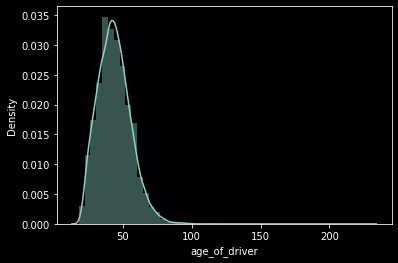

In [16]:
# ▶ age_of_driver(운전자 나이)에 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.distplot(df['age_of_driver']);

In [17]:
# ▶ 구간화
import numpy as np
df['age_of_driver_gp'] = np.where (df['age_of_driver'] <= 30, 1, 
                           np.where(df['age_of_driver'] <= 50, 2, 3))

df[['age_of_driver','age_of_driver_gp']]

age_of_driver  age_of_driver_gp
0                 46                 2
1                 21                 1
2                 49                 2
3                 58                 3
4                 38                 2
...              ...               ...
17993             69                 3
17994             35                 2
17995             27                 1
17996             52                 3
17997             61                 3

[17973 rows x 2 columns]

In [18]:
# ▶ 구간화에 따른 청구 사기율
num_val='age_of_driver_gp'

# ▶ 1단계
df_tran = pd.DataFrame(df.groupby([num_val, 'fraud'])['claim_number'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = num_val,           # 행 위치에 들어갈 열
                      columns = 'fraud',         # 열 위치에 들어갈 열
                      values = 'claim_number')   # 데이터로 사용할 열 
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,2] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

age_of_driver_gp     0     1  ratio
0                 1  2047   378   15.6
1                 2  8838  1981   18.3
2                 3  4276   453    9.6

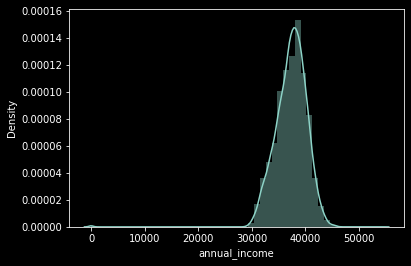

In [19]:
# ▶ annual_income(연소득)에 분포 확인
sns.distplot(df['annual_income']);

In [20]:
# ▶ 구간화
import numpy as np
df['annual_income_gp'] = np.where (df['annual_income'] <= 35000, 1, 
                           np.where(df['annual_income'] <= 40000, 2, 3))

df[['annual_income','annual_income_gp']]

annual_income  annual_income_gp
0              38301                 2
1              30445                 1
2              38923                 2
3              40605                 3
4              36380                 2
...              ...               ...
17993          42338                 3
17994          35579                 2
17995          32953                 1
17996          39519                 2
17997          41126                 3

[17973 rows x 2 columns]

In [21]:
# ▶ 구간화에 따른 청구 사기율
cat_val='annual_income_gp'

# ▶ 1단계
df_tran = pd.DataFrame(df.groupby([cat_val, 'fraud'])['claim_number'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = cat_val,           # 행 위치에 들어갈 열
                      columns = 'fraud',         # 열 위치에 들어갈 열
                      values = 'claim_number')   # 데이터로 사용할 열 
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,2] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

annual_income_gp     0     1  ratio
0                 1  3134   592   15.9
1                 2  9222  1911   17.2
2                 3  2805   309    9.9

### · Categorical 변수 
---

In [22]:
df[categoical_list]

gender living_status  claim_date claim_day_of_week accident_site  \
0          M          Rent  12/16/2016            Friday         Local   
1          F          Rent   2/12/2015          Thursday       Highway   
2          F           Own   12/6/2016           Tuesday         Local   
3          F           Own    5/5/2016          Thursday         Local   
4          M          Rent  10/27/2015           Tuesday       Highway   
...      ...           ...         ...               ...           ...   
17993      M           Own   3/28/2015          Saturday         Local   
17994      F           Own    1/5/2015            Monday         Local   
17995      F          Rent   9/10/2016          Saturday         Local   
17996      F           Own  12/25/2015            Friday       Highway   
17997      F          Rent   9/26/2016            Monday   Parking Lot   

      channel vehicle_category vehicle_color  
0      Broker          Compact         white  
1      Online            Large         white  
2      Broker          Compact         white  
3      Broker           Medium         other  
4      Broker           Medium          gray  
...       ...              ...           ...  
17993  Broker           Medium         black  
17994   Phone           Medium          blue  
17995  Online           Medium         black  
17996  Broker          Compact         white  
17997   Phone           Medium          blue  

[17973 rows x 8 columns]

In [23]:
df['claim_date'].head(5)

0    12/16/2016
1     2/12/2015
2     12/6/2016
3      5/5/2016
4    10/27/2015
Name: claim_date, dtype: object

In [24]:
# ▶ 날짜 데이터 전처리 (※ split 사용)
df['year'] = df['claim_date'].apply(lambda x: x.split('/')[2])
df['month'] = df['claim_date'].apply(lambda x: x.split('/')[0])

df[['claim_date', 'year', 'month']]

claim_date  year month
0      12/16/2016  2016    12
1       2/12/2015  2015     2
2       12/6/2016  2016    12
3        5/5/2016  2016     5
4      10/27/2015  2015    10
...           ...   ...   ...
17993   3/28/2015  2015     3
17994    1/5/2015  2015     1
17995   9/10/2016  2016     9
17996  12/25/2015  2015    12
17997   9/26/2016  2016     9

[17973 rows x 3 columns]

In [25]:
print("categoical_list :", categoical_list)

categoical_list : ['gender', 'living_status', 'claim_date', 'claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color']


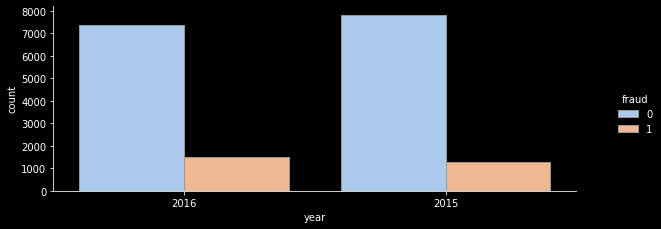

In [26]:
# ▶ 년도별 청구 사기율 비교 
sns.catplot(x="year", hue="fraud", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)

In [27]:
cat_val='year'

# ▶ 1단계
df_tran = pd.DataFrame(df.groupby([cat_val, 'fraud'])['claim_number'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = cat_val,           # 행 위치에 들어갈 열
                      columns = 'fraud',         # 열 위치에 들어갈 열
                      values = 'claim_number')   # 데이터로 사용할 열 
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,2] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot.sort_values(by=['ratio'], ascending = False)

year     0     1  ratio
1  2016  7355  1520   17.1
0  2015  7806  1292   14.2

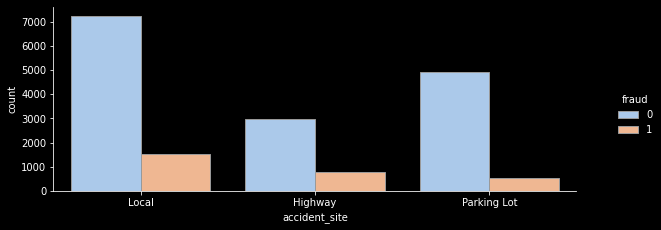

In [28]:
# ▶ 사고현장에 따른 청구 사기율 비교
sns.catplot(x="accident_site", hue="fraud", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)

In [29]:
# ▶ 고속도로 > 동네 > 주차장 순으로 청구 사기건이 많음
cat_val='accident_site'

# ▶ 1단계
df_tran = pd.DataFrame(df.groupby([cat_val, 'fraud'])['claim_number'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = cat_val,           # 행 위치에 들어갈 열
                      columns = 'fraud',         # 열 위치에 들어갈 열
                      values = 'claim_number')   # 데이터로 사용할 열 
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,2] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot.sort_values(by=['ratio'], ascending = False)

accident_site     0     1  ratio
0       Highway  2980   772   20.6
1         Local  7251  1509   17.2
2   Parking Lot  4930   531    9.7


## **🥇Session 3**  
**┗ ML 활용 사기 거래 예측**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [30]:
df.head(5)

claim_number  age_of_driver gender  marital_status  safty_rating  \
0             1             46      M             1.0            85   
1             3             21      F             0.0            75   
2             4             49      F             0.0            87   
3             5             58      F             1.0            58   
4             6             38      M             1.0            95   

   annual_income  high_education_ind  address_change_ind living_status  \
0          38301                   1                   1          Rent   
1          30445                   0                   1          Rent   
2          38923                   0                   1           Own   
3          40605                   1                   0           Own   
4          36380                   1                   0          Rent   

   zip_code  ... age_of_vehicle vehicle_category vehicle_price  vehicle_color  \
0     80006  ...            9.0          Compact   12885.45235          white   
1     15021  ...            4.0            Large   29429.45218          white   
2     20158  ...            3.0          Compact   21701.18195          white   
3     15024  ...            4.0           Medium   13198.27344          other   
4     50034  ...            7.0           Medium   38060.21122           gray   

   vehicle_weight  fraud age_of_driver_gp  annual_income_gp  year  month  
0     16161.33381      0                2                 2  2016     12  
1     28691.96422      0                1                 1  2015      2  
2     22090.94758      1                2                 2  2016     12  
3     38329.58106      1                3                 3  2016      5  
4     25876.56319      0                2                 2  2015     10  

[5 rows x 29 columns]

In [31]:
df.columns

Index(['claim_number', 'age_of_driver', 'gender', 'marital_status',
       'safty_rating', 'annual_income', 'high_education_ind',
       'address_change_ind', 'living_status', 'zip_code', 'claim_date',
       'claim_day_of_week', 'accident_site', 'past_num_of_claims',
       'witness_present_ind', 'liab_prct', 'channel',
       'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle',
       'vehicle_category', 'vehicle_price', 'vehicle_color', 'vehicle_weight',
       'fraud', 'age_of_driver_gp', 'annual_income_gp', 'year', 'month'],
      dtype='object')

In [33]:
# ▶ 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구분하는 단계 
# ▶ year, month는 새로운 파생 변수로서 추가 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df.drop(['claim_number', 'claim_date', 'year','age_of_driver_gp', 'annual_income_gp','fraud'], axis=1)
Y=df['fraud']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(12581, 23)
(12581,)
(5392, 23)
(5392,)


In [34]:
categoical_list

['gender',
 'living_status',
 'claim_date',
 'claim_day_of_week',
 'accident_site',
 'channel',
 'vehicle_category',
 'vehicle_color']

In [35]:
# ▶ 사용하지 않을 Categorical 변수는 리스트에서 제외
categoical_list.remove('claim_date')

In [36]:
# ▶ 새로 추가한 변수는 없기 때문에 추가
categoical_list.append('month')
categoical_list

['gender',
 'living_status',
 'claim_day_of_week',
 'accident_site',
 'channel',
 'vehicle_category',
 'vehicle_color',
 'month']

In [37]:
df[categoical_list]

gender living_status claim_day_of_week accident_site channel  \
0          M          Rent            Friday         Local  Broker   
1          F          Rent          Thursday       Highway  Online   
2          F           Own           Tuesday         Local  Broker   
3          F           Own          Thursday         Local  Broker   
4          M          Rent           Tuesday       Highway  Broker   
...      ...           ...               ...           ...     ...   
17993      M           Own          Saturday         Local  Broker   
17994      F           Own            Monday         Local   Phone   
17995      F          Rent          Saturday         Local  Online   
17996      F           Own            Friday       Highway  Broker   
17997      F          Rent            Monday   Parking Lot   Phone   

      vehicle_category vehicle_color month  
0              Compact         white    12  
1                Large         white     2  
2              Compact         white    12  
3               Medium         other     5  
4               Medium          gray    10  
...                ...           ...   ...  
17993           Medium         black     3  
17994           Medium          blue     1  
17995           Medium         black     9  
17996          Compact         white    12  
17997           Medium          blue     9  

[17973 rows x 8 columns]

In [38]:
# ▶ Categorical(범주형) 변수는 One-hot-encoding or Label-encoding을 통해 숫자형 변수로 변경해야함
# ▶ One-hot-encoding은 차원이 많은 변수에는 불리, Label-encoding은 회귀관련 알고리즘에서는 사용 어려움.(※Tree 계열 알고리즘에서는 사용 가능)
from sklearn.preprocessing import LabelEncoder

for col in categoical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

gender
living_status
claim_day_of_week
accident_site
channel
vehicle_category
vehicle_color
month


In [39]:
x_train[categoical_list].head(3)

gender  living_status  claim_day_of_week  accident_site  channel  \
15519       1              0                  3              2        0   
9335        0              0                  6              2        0   
4048        0              1                  2              2        2   

       vehicle_category  vehicle_color  month  
15519                 0              0      4  
9335                  0              1     11  
4048                  0              4      7

In [40]:
x_test[categoical_list].head(3)

gender  living_status  claim_day_of_week  accident_site  channel  \
9187       1              0                  1              0        2   
6866       1              0                  6              1        0   
7666       1              1                  6              1        0   

      vehicle_category  vehicle_color  month  
9187                 1              4      0  
6866                 2              2      9  
7666                 0              1      0

### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [56]:
import lightgbm as lgb
# ▶ Hyper parametre setting

d_train = lgb.Dataset (x_train, label = y_train)

params = {} 
params [ 'learning_rate'] = 0.02
params [ 'boosting_type'] = 'gbdt' # GradientBoostingDecisionTree
params ['objective'] = 'binary'
params [ 'metric' ] = 'binary_logloss' # metric for binary-class
params [ 'max_depth'] = 2
params [ 'num_leaves' ] = 4 # 최대 leaves는 2^(max_depth)
params ['seed'] = 23456
# ▶ 학습
clf = lgb.train (params, d_train, 500) # 1000 epocs에서 모델 훈련

In [61]:
from sklearn.metrics import classification_report

y_pred_train = clf.predict(x_train)
for i in range(0,len(y_pred_train)):
    if y_pred_train[i]>=.3:       # setting threshold to .5
       y_pred_train[i]=1
    else:  
       y_pred_train[i]=0

y_pred_test = clf.predict(x_test)
for i in range(0,len(y_pred_test)):
    if y_pred_test[i]>=.3:       # setting threshold to .5
       y_pred_test[i]=1
    else:  
       y_pred_test[i]=0



print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     10613
           1       0.48      0.19      0.27      1968

    accuracy                           0.84     12581
   macro avg       0.67      0.58      0.59     12581
weighted avg       0.80      0.84      0.81     12581

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4548
           1       0.40      0.17      0.24       844

    accuracy                           0.83      5392
   macro avg       0.63      0.56      0.57      5392
weighted avg       0.79      0.83      0.80      5392



In [62]:
pd.Series(y_pred_test).value_counts()

0.0    5034
1.0     358
dtype: int64

In [63]:
# 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = clf.predict(x_train)
y_pred_test_proba = clf.predict(x_test)


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.7488108760233462
roc_score_test : 0.7186926861242064


In [64]:
from sklearn.metrics import roc_curve
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    # FPR : 암환자가 아닌 환자를 암환자라고 잘 못 예측한 비율
    # TPR : Recall
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random', color='red')
  
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

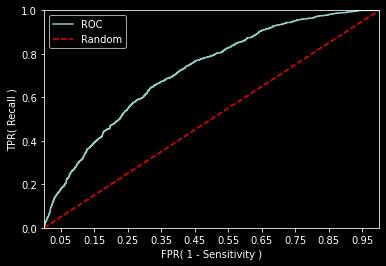

In [65]:
roc_curve_plot(y_test, y_pred_test_proba)

### · 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

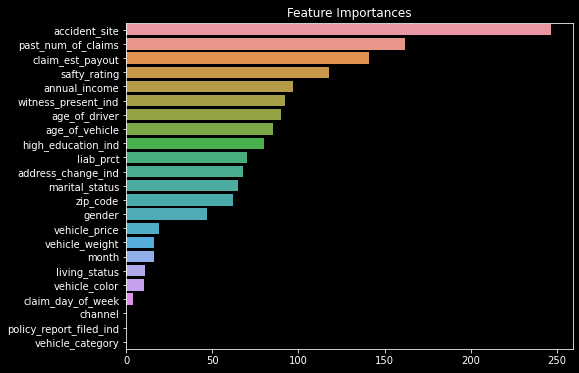

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = clf.feature_importance()
ftr_importances = pd.Series(ftr_importances_values, index = X.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

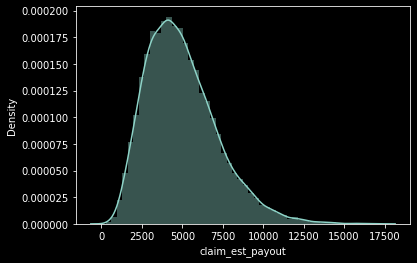

In [67]:
# ▶ 중요변수 대한 상세 탐색
sns.distplot(df['claim_est_payout']);

In [68]:
# ▶ 구간화
import numpy as np
df['claim_est_payout_gp'] = np.where (df['claim_est_payout'] <= 2500, 1, 
                           np.where(df['claim_est_payout'] <= 7500, 2, 3))

df[['claim_est_payout','claim_est_payout_gp']]

claim_est_payout  claim_est_payout_gp
0           7530.940993                    3
1           2966.024895                    2
2           6283.888333                    2
3           6169.747994                    2
4           4541.387150                    2
...                 ...                  ...
17993       4806.841803                    2
17994       4089.794471                    2
17995       2225.803056                    1
17996       9560.744844                    3
17997       5166.915270                    2

[17973 rows x 2 columns]

In [69]:
df.groupby(['claim_est_payout_gp', 'fraud'])['fraud'].count()

claim_est_payout_gp  fraud
1                    0         1588
                     1          404
2                    0        11703
                     1         1998
3                    0         1870
                     1          410
Name: fraud, dtype: int64

In [70]:
# ▶ claim_est_payout(지급보험료)가 작은 청구건수 일수록 청구 사기건일 확률이 높음
print("gp1 :", 404 / (404+1588))
print("gp2 :", 1998 / (1998+11703))
print("gp3 :", 410 / (410+1870))

gp1 : 0.20281124497991967
gp2 : 0.14582877162250932
gp3 : 0.17982456140350878


### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(clf)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)